# Final Project - Advanced Topics in Computer Science 8
Yehonatan Peisakhovsky yehonatan-pe@campus.technion.ac.il ?????????
Ido Zuckerman ido.z@campus.technion.ac.il 323102830

## Topic
?????

## Introduction
?????

## Research Question
?????

## Assumptions
?????


## Methods and Experiments
????? (expiremnts and metrics)

## Results

In [3]:
from enviorment import Env
from utils import *
from sklearn.model_selection import KFold
from sklearn.metrics import ndcg_score
from tqdm import tqdm
import random
from collections import defaultdict
import matplotlib.pyplot as plt

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\idozu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Hyperparameters

In [4]:
amount_of_queries = 50
k = 5
Epochs = 3

#### Preprocess

In [5]:
docs, queries, rel = create_documents_queries_and_relevence()
queries_with_relevant_docs = list(rel.keys())
queries = {k: queries[k] for k in queries_with_relevant_docs}
docs, queries = preprocess_data(docs, queries)

#### Example

In [4]:
# Chosen queries to work with and do cross validation
chosen_queries = [x for x in queries.keys()][:amount_of_queries]
cv = KFold(k)
undisturbed_ndcgs = defaultdict(float)
disturbed_ndcgs = defaultdict(float)
for strategic_per in tqdm(np.arange(0.1, 1, 0.3)):
    for number_of_word_to_add in range(0, 10000, 2000):
        # random.seed(10)
        # np.random.seed(10)
        # original ndcg without changing the documents
        undisturbed_ndcg = []
        # Ndcg after the change
        disturbed_ndcg = []
        for train_indices, test_indices in cv.split(chosen_queries):
            # The ids of the queries used to train,
            # they actually matter just when using rank svm
            train_queries_ids = [chosen_queries[x] for x in train_indices]
            # The ids of the queries used to test the model
            test_queries_ids = [chosen_queries[x] for x in test_indices]
            train_queries = {k: queries[k] for k in train_queries_ids}
            train_rel = {k: rel[k] for k in train_queries_ids}
            test_queries = {k: queries[k] for k in test_queries_ids}
            test_rel = {k: rel[k] for k in test_queries_ids}
            # Assigns random values to the queries, we can change seed
            queries_worth = create_queries_worth(test_queries)
            # Environment initialization
            environment = Env(docs=docs, strategic_percentage=strategic_per, model_type="okapi_bm25",
                              number_of_word_to_add=number_of_word_to_add, train_queries=train_queries,
                              train_relevance_ranking=train_rel, seed=10)
            # Epochs represents the amount of time we change which agents are chosen to
            # be strategic. We need to talk about how they are chosen, because now they are random
            # meaning if we run too many epochs then the ndcg with or without corruption will
            # be the same (because sometimes strategic agents are relevant and pushed up, sometimes
            # not relevant are pushed up.
            for i in range(Epochs):
                environment.change_config()
                # Scores of unchanged documents and real ndcg
                queries_scores = environment.run(test_queries)
                for query_id, scores in queries_scores.items():
                    gt = np.array([[1 if i in test_rel[query_id] else 0 for i in docs.keys()]])
                    undisturbed_ndcg.append(ndcg_score(gt, scores))
                # Makes strategic agents change their documents
                environment.corrupt(test_queries, queries_worth)
                # Scores after documents change
                queries_scores = environment.run(test_queries)
                for query_id, scores in queries_scores.items():
                    gt = np.array([[1 if i in test_rel[query_id] else 0 for i in docs.keys()]])
                    disturbed_ndcg.append(ndcg_score(gt, scores))
        print(f"Undisturbed ndcg {np.mean(undisturbed_ndcg):.4f}")
        print(f"Disturbed ndcg {np.mean(disturbed_ndcg):.4f}")
        undisturbed_ndcgs[(strategic_per, number_of_word_to_add)] = np.mean(undisturbed_ndcg)
        disturbed_ndcgs[(strategic_per, number_of_word_to_add)] = np.mean(disturbed_ndcg)

  0%|          | 0/3 [00:00<?, ?it/s]

Undisturbed ndcg 0.4053
Disturbed ndcg 0.4053
Undisturbed ndcg 0.4063
Disturbed ndcg 0.4069
Undisturbed ndcg 0.4064
Disturbed ndcg 0.4070
Undisturbed ndcg 0.4064
Disturbed ndcg 0.4069


 33%|███▎      | 1/3 [01:12<02:25, 72.61s/it]

Undisturbed ndcg 0.4063
Disturbed ndcg 0.4068
Undisturbed ndcg 0.4053
Disturbed ndcg 0.4053
Undisturbed ndcg 0.4046
Disturbed ndcg 0.4050
Undisturbed ndcg 0.4047
Disturbed ndcg 0.4052
Undisturbed ndcg 0.4047
Disturbed ndcg 0.4050


 67%|██████▋   | 2/3 [03:15<01:42, 102.03s/it]

Undisturbed ndcg 0.4047
Disturbed ndcg 0.4050
Undisturbed ndcg 0.4053
Disturbed ndcg 0.4053
Undisturbed ndcg 0.4054
Disturbed ndcg 0.4056
Undisturbed ndcg 0.4055
Disturbed ndcg 0.4057
Undisturbed ndcg 0.4055
Disturbed ndcg 0.4057


100%|██████████| 3/3 [06:07<00:00, 122.62s/it]

Undisturbed ndcg 0.4055
Disturbed ndcg 0.4057


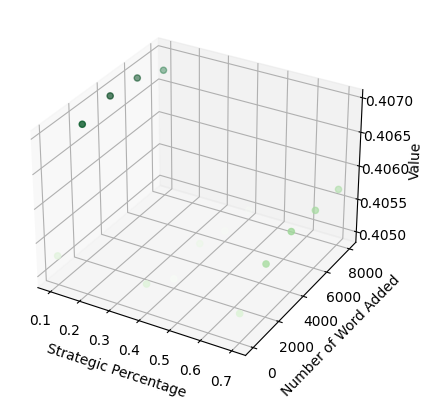

In [5]:
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
keys = np.array([[x, y, value] for (x, y), value in disturbed_ndcgs.items()])
zdata = keys[:, 2]
xdata = keys[:, 0]
ydata = keys[:, 1]
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')

ax.set_xlabel("Strategic Percentage")
ax.set_ylabel("Number of Word Added")
ax.set_zlabel("Value")
plt.show()

# Temp Experiments

In [6]:
def run_exp(strategic_per_nums, number_of_word_to_add_nums, model):
    print(f"\nModel: {model}\tstrategic_per: {strategic_per_nums}\tnumber_of_word_to_add: {number_of_word_to_add_nums}")
    # Chosen queries to work with and do cross validation
    chosen_queries = [x for x in queries.keys()][:amount_of_queries]
    cv = KFold(5)
    undisturbed_ndcgs = defaultdict(float)
    disturbed_ndcgs = defaultdict(float)
    for strategic_per in tqdm(strategic_per_nums):
        for number_of_word_to_add in number_of_word_to_add_nums:
            # random.seed(10)
            # np.random.seed(10)
            # original ndcg without changing the documents
            undisturbed_ndcg = []
            # Ndcg after the change
            disturbed_ndcg = []
            for train_indices, test_indices in cv.split(chosen_queries):
                # The ids of the queries used to train,
                # they actually matter just when using rank svm
                train_queries_ids = [chosen_queries[x] for x in train_indices]
                # The ids of the queries used to test the model
                test_queries_ids = [chosen_queries[x] for x in test_indices]
                train_queries = {k: queries[k] for k in train_queries_ids}
                train_rel = {k: rel[k] for k in train_queries_ids}
                test_queries = {k: queries[k] for k in test_queries_ids}
                test_rel = {k: rel[k] for k in test_queries_ids}
                # Assigns random values to the queries, we can change seed
                queries_worth = create_queries_worth(test_queries)
                # Environment initialization
                environment = Env(docs=docs, strategic_percentage=strategic_per, model_type=model,
                                  number_of_word_to_add=number_of_word_to_add, train_queries=train_queries,
                                  train_relevance_ranking=train_rel, seed=10)
                # Epochs represents the amount of time we change which agents are chosen to
                # be strategic. We need to talk about how they are chosen, because now they are random
                # meaning if we run too many epochs then the ndcg with or without corruption will
                # be the same (because sometimes strategic agents are relevant and pushed up, sometimes
                # not relevant are pushed up.
                for i in range(Epochs):
                    environment.change_config()
                    # Scores of unchanged documents and real ndcg
                    queries_scores = environment.run(test_queries)
                    for query_id, scores in queries_scores.items():
                        gt = np.array([[1 if i in test_rel[query_id] else 0 for i in docs.keys()]])
                        undisturbed_ndcg.append(ndcg_score(gt, scores))
                    # Makes strategic agents change their documents
                    environment.corrupt(test_queries, queries_worth)
                    # Scores after documents change
                    queries_scores = environment.run(test_queries)
                    for query_id, scores in queries_scores.items():
                        gt = np.array([[1 if i in test_rel[query_id] else 0 for i in docs.keys()]])
                        disturbed_ndcg.append(ndcg_score(gt, scores))
            # print(f"Undisturbed ndcg {np.mean(undisturbed_ndcg):.4f}")
            # print(f"Disturbed ndcg {np.mean(disturbed_ndcg):.4f}")
            undisturbed_ndcgs[(strategic_per, number_of_word_to_add)] = np.mean(undisturbed_ndcg)
            disturbed_ndcgs[(strategic_per, number_of_word_to_add)] = np.mean(disturbed_ndcg)

    ax = plt.axes(projection='3d')

    # Data for three-dimensional scattered points
    keys = np.array([[x, y, value] for (x, y), value in disturbed_ndcgs.items()])
    zdata = keys[:, 2]
    xdata = keys[:, 0]
    ydata = keys[:, 1]
    ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')

    ax.set_xlabel("Strategic Percentage")
    ax.set_ylabel("Number of Word Added")
    ax.set_zlabel("Value")
    ax.set_title(f"Model: {model}")
    plt.show()


Model: okapi_bm25	strategic_per: [0.  0.2 0.4 0.6 0.8]	number_of_word_to_add: range(0, 10000, 2000)


100%|██████████| 5/5 [10:26<00:00, 125.25s/it]


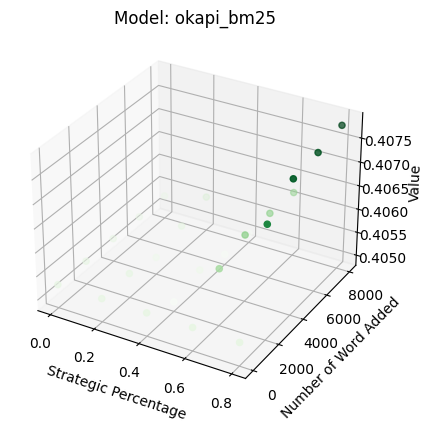


Model: tf_idf	strategic_per: [0.  0.2 0.4 0.6 0.8]	number_of_word_to_add: range(0, 10000, 2000)


100%|██████████| 5/5 [22:22<00:00, 268.60s/it]


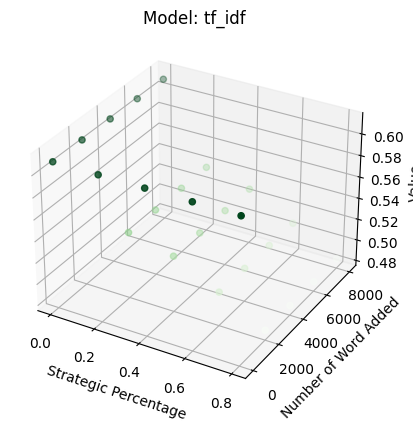


Model: rank_svm	strategic_per: [0.  0.2 0.4 0.6 0.8]	number_of_word_to_add: range(0, 10000, 2000)


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
run_exp(np.arange(0, 1, 0.2), range(0, 10000, 2000), "okapi_bm25")
run_exp(np.arange(0, 1, 0.2), range(0, 10000, 2000), "tf_idf")
run_exp(np.arange(0, 1, 0.2), range(0, 10000, 2000), "rank_svm")

## Discussion
?????

## Limitations
?????